# Complex in droplet simulation

In [1]:
%pylab inline
import scipy.constants
import time
import popdrop

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
# Molar protein concentration
#c_molar = 2.5E-6 # [mol/l]
c_molar = 100E-6
#c_molar = 200E-6 # [mol/l]
# Protein mass
m_P = 53.3E3 # [Da]
# Simulation volume
V = 0.125E-18 # [m^3]
# Correction factor
x = 2.
# Droplet radius (will be later rescaled to R_D_ksi)
R_D = 9.E-9

## Constants

In [3]:
# Protein mass density
rho_P = 0.84 / (1E-10)**3 # [Da/m^3]

## Derived parameters

In [4]:
# Hard sphere radius of protein
R_S = (m_P/rho_P * 3./4./pi)**(1/3.)
# Rescaled droplet radius
#R_D_xi = R_D * x
R_D_xi = array([20,25,30,35])*1E-9
# Rescaled droplet volume
V_D_xi = 4/3.*pi*R_D_xi**3
# SI protein concentration
c = c_molar * scipy.constants.Avogadro / 0.1**3 # [1/m^3]
# Expectation value for number of particles per droplet
p_D_xi = c * V_D_xi
# Number of particles in virutual box
N = int(round(V * c))
# Edge length of virtual box
L = V**(1/3.)

## Assign positions

In [5]:
from python_tools import multiprocesstools as mpt

In [6]:
import logging
logger = logging.getLogger("drop")
import h5py
Nprocesses = 16
Njobs = 50000
results = []
def worker_i(D, i):
    return {"pos" : popdrop.popdrop(N, L, R_S, R_D_xi[i])}
def getwork():
    return {}
def logres_i(res, i):
    with h5py.File("drops_%i.h5" % i, "r+") as f:
        i = f["/i"][0]
        n_particles = len(res["pos"])
        f["/n_particles"][i] = n_particles
        if n_particles > 0:
            n = min([n_particles,f["/pos"].shape[1]])
            f["/pos"][i,:n,:] = res["pos"][:,:]
        f["/i"][0] = i + 1
def loginit_i(i, N_max=10):
    with h5py.File("drops_%i.h5" % i, "w") as f:
        f["/n_particles"] = numpy.zeros(shape=(Njobs))
        f["/pos"] = numpy.zeros(shape=(Njobs,N_max,3))
        f["/i"] = [0]
def getres_i(i):
    with h5py.File("drops_%i.h5" % i, "r") as f:
        pos = array(f["/pos"])
        n_particles = array(f["/n_particles"])
    return n_particles,pos

In [7]:
n_particles = []
res = []
for i in range(len(R_D_xi)):
    print i, R_D_xi[i]
    loginit_i(i, N_max=40)
    print "initialised"
    mpt.multiprocess(Nprocesses,
                     Njobs, 
                     lambda D: worker_i(D, i),
                     getwork, 
                     logres = lambda res:logres_i(res, i),
                     logger = logger)
    print "mp started"
    n_particles_i,res_i = getres_i(i)
    print "collect res"
    n_particles.append(n_particles_i)
    res.append(res_i)

0 2e-08
initialised
mp started
collect res
1 2.5e-08
initialised
mp started
collect res
2 3e-08
initialised
mp started
collect res
3 3.5e-08
initialised
mp started
collect res


## Compare to Poisson distribution

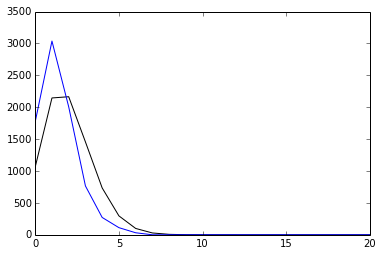

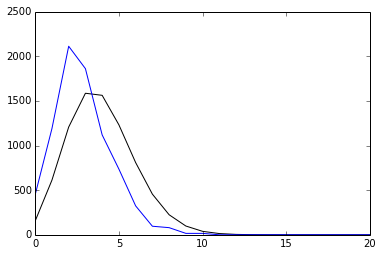

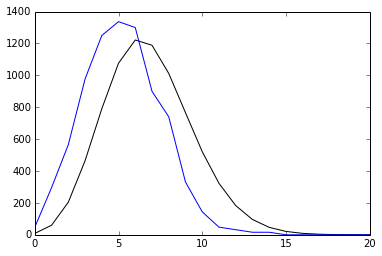

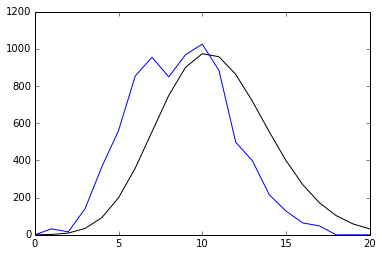

In [11]:
from scipy.misc import factorial
for i, res_i, n_particles_i in zip(range(len(res)), res, n_particles):
    H = histogram(n_particles_i, bins=21, range=(0,21))
    hist_n = H[0]
    hist_bins = H[1]
    hist_bins = hist_bins[:-1] #+ (hist_bins[1]-hist_bins[0])/2.
    poisson_model = lambda k,l: (l**k*exp(-l))/factorial(k)
    hist_n_poisson = array([poisson_model(n, p_D_xi[i]) for n in hist_bins])
    figure()
    plot(hist_bins, hist_n_poisson*hist_n.sum()/hist_n_poisson.sum(),c="black")
    plot(hist_bins, hist_n,c='blue')